## Processing of imaging data using max-projection (i.e. data compressed to 3D)

This preprocessing pipeline can be used to process  single-plane imaging data (3D) or volume imaging data (4D). In the latter case, the volume is collapsed through a max projection.

In [1]:
from ScanImageTiffReader import ScanImageTiffReader
import json
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import numpy as np

#from sys import path
from os.path import sep, exists
from os import mkdir, makedirs, getcwd

import napari
import xarray as xr
import pandas as pd

%gui qt5
%config Completer.use_jedi = False  #magic to fix autocomplete issue

In [2]:
from fly2p.viz.viz import myAxisTheme, plotDFFheatmap
import fly2p.preproc.imgPreproc as imp
from fly2p.preproc.scanImageUtils import getSIbasicMetadata, getSIMetadict, loadvolume

#### Set paths to data files and plot directory

In [3]:
dataDir = '../sample/'
rawTiff = 'SS96-x-7f_EB_sample.tif'
genotype = 'SS96-x-GCaMP7f'
flyID = 'testfly'
trial = 'test'
region = 'ellipsoid body'
        
saveDir = dataDir
preprocDir = dataDir
# Generate directory where to save plots
if not exists(saveDir): makedirs(saveDir)
if not exists(preprocDir): makedirs(preprocDir)

#### Load data and perform motion correction

In [4]:
mytiffreader = ScanImageTiffReader(sep.join([dataDir, rawTiff]))
basicMetadat = getSIbasicMetadata(mytiffreader.metadata())
basicMetadat["CaCh"] = 0 # give channel identity
SImetadict = getSIMetadict(mytiffreader.metadata())

SI.VERSION_COMMIT = '4a9264c4fccd21a03258704d0d6489537ad79e6c'
SI.VERSION_MAJOR = '2018b'
SI.VERSION_MINOR = '1'


In [5]:
basicMetadat

{'nCh': 1,
 'fpsscan': 95.509,
 'discardFBFrames': 'true',
 'nDiscardFBFrames': 2,
 'fpv': 10,
 'nVols': 4584,
 'stackZStepSize': 6.0,
 'scanVolumeRate': 9.5509,
 'fovCoords': {'p00': [-20.25, -20.25],
  'p10': [20.25, 20.25],
  'p01': [20.25, -20.25],
  'p11': [-20.25, 20.25]},
 'xrange_um': 40.5,
 'yrange_um': 40.5,
 'CaCh': 0}

In [6]:
# Load data: With larger file sizes, the scanimage loader fails (idk why)
stack = loadvolume(sep.join([dataDir, rawTiff]), basicMetadat, selectCaChan=True)
imgStack = imp.stack2xarray(stack, basicMetadat)

Check if reference image is good: It should not be to biased by transient activity peaks.

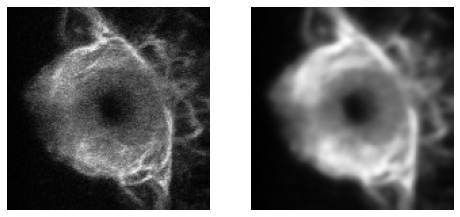

In [7]:
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume

numRefImg = 20
refstart = 100
locRefImg = round(stackMP['volumes [s]'].size/2)

# Generate reference image
refImg = np.mean(stackMP[locRefImg:locRefImg+numRefImg,:,:],axis=0) + np.mean(stackMP[refstart:refstart+numRefImg,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');

perform motion correction on a single plane/max projection


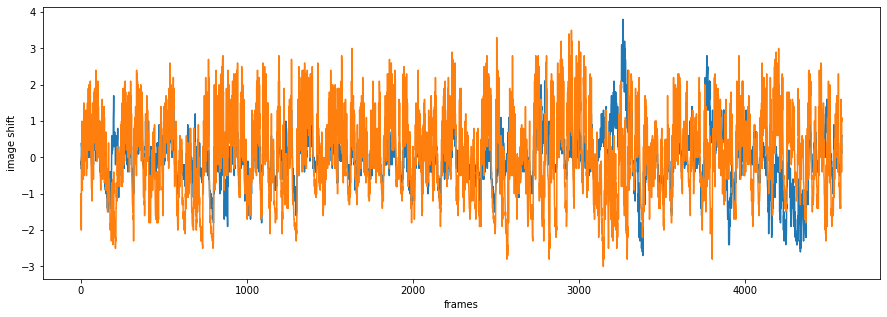

In [8]:
# If there are unreasonable shifts select "doFilter=True".

shift = imp.computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)
stackMPMC = imp.motionCorrection(stackMP, shift)

#### Compute DFF

In [9]:
## Settings
# settings for Savitzky-Golay filter (default: 3rd order, 7 frames)
order = 3
window = 7

# Currently F_0 is estimated for each pixel on the whole time series (ok, if time series is short)
baseLinePercent = 10
offset = 0.0001

***Specify region for background subtraction***
* Paint a small region named "background" using a brush in the Labels menu in the napari gui. This region should not overlap with the intended signal roi.
* If there is an existing mask placed in the preprocessing folder of the fly and/or tiral, it will be loaded automatically
* If subtracting using rolling ball, skip the next 2 cells

In [10]:
# you can draw a mask on the foreground
viewer = napari.view_image(stackMPMC.mean(axis=0), contrast_limits=[stackMPMC.data.mean(axis=0).min(),np.percentile(stackMPMC.mean(axis=0), 99.9)])

if exists(sep.join([preprocDir,'background.npy'])):
    background = np.load(sep.join([preprocDir,'background.npy'])) 
    viewer.add_labels(background, name='background')

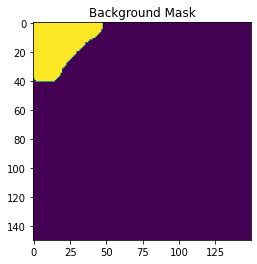

In [11]:
background = viewer.layers["background"].data

if not exists(preprocDir): makedirs(sep.join([preprocDir]))
np.save(sep.join([preprocDir,'background']), background)
viewer.close()

plt.imshow(background);
plt.title("Background Mask");

In [12]:
dffStack, stackF0 = imp.computeDFF(stackMPMC, order, window, baseLinePercent, offset)
dffXarray = imp.stack2xarray(dffStack, basicMetadat, data4D = False)
F0Xarray = imp.refStack2xarray(stackF0, basicMetadat, data4D = False)

processing 3d stack


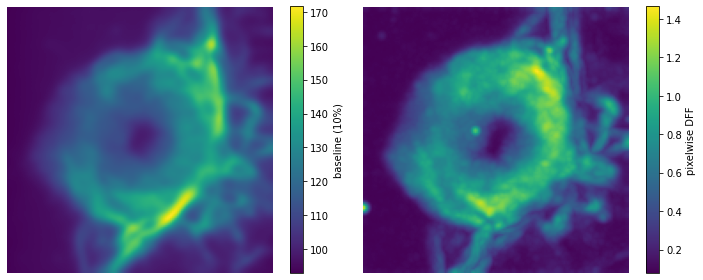

In [13]:
dffMP = np.max(dffStack,axis=0)
fig, ax = plt.subplots(1,2,figsize=(10,4))
cb = ax[0].imshow(stackF0,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[0], label='baseline ({}%)'.format(baseLinePercent))
ax[0].axis('off')
cb = ax[1].imshow(dffMP,cmap='viridis',origin='upper')#, vmin=0, vmax=10)
plt.colorbar(cb, ax=ax[1], label='pixelwise DFF')
ax[1].axis('off')
fig.tight_layout()
#viewerdff = napari.view_image(dffStackMC)
fig.savefig(saveDir+sep+'BaselineAndDFF_MIP.pdf')

### Generate ROIs automatically
We will do this here only for pixels within a manually drawn mask, but it also works fine without a mask.

In [14]:
# you can draw a mask to constraint which pixels will be included in corrleation analysis
viewer = napari.view_image(refImgFilt)
if exists(sep.join([preprocDir,'mask.npy'])):
    mask = np.load(sep.join([preprocDir,'mask.npy'])) 
    viewer.add_labels(mask, opacity=0.2)

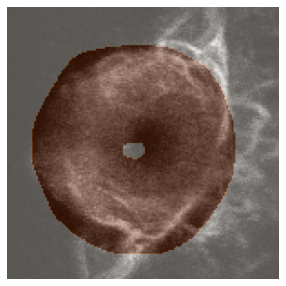

In [15]:
mask = viewer.layers["mask"]
viewer.close()
if not exists(sep.join([preprocDir,'mask.npy'])):
    if not exists(sep.join([preprocDir])): makedirs(sep.join([preprocDir]))
    np.save(sep.join([preprocDir,'mask']), mask.data)
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.imshow(refImg,cmap='Greys_r',origin='upper')
ax.axis('off');
ax.imshow(mask.data, cmap='Oranges', alpha=0.35)
fig.savefig(saveDir+sep+'mask.pdf')

In [16]:
from sklearn.cluster import KMeans
nclst = 10

toClust = dffStack[:,mask.data>0]
kmeans = KMeans(n_clusters=nclst)
kmeans.fit(toClust.T)

kmlabs = kmeans.predict(toClust.T)
centroids = kmeans.cluster_centers_

In [17]:
myClstMap = 'tab20b_r'
cNorm  = colors.Normalize(vmin=1, vmax=nclst)
clstCMap = plt.cm.ScalarMappable(norm=cNorm,cmap=myClstMap)

time = dffXarray.coords['volumes [s]'].values

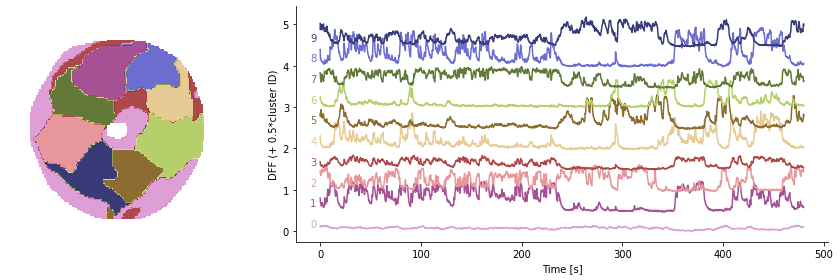

In [18]:
kmlabsImg = np.nan*np.ones(mask.data.shape)

kmlabsImg[mask.data>0] = kmlabs

fig, axs = plt.subplots(1,2,figsize=(12,4), gridspec_kw={'width_ratios':[1,2]})

axs[0].imshow(kmlabsImg,cmap=myClstMap,origin='upper')
axs[0].axis('off')

for i in range(nclst):
    axs[1].plot(time,centroids[i]+i*0.5, color=clstCMap.to_rgba(i+1))
    axs[1].text(-10,i*0.5+.1,str(i),color=clstCMap.to_rgba(i+1))
axs[1].set_xlabel('Time [s]')
axs[1].set_ylabel('DFF (+ 0.5*cluster ID)')
myAxisTheme(axs[1])
fig.tight_layout()
fig.savefig(saveDir+sep+'ROIcluster_kn{}.pdf'.format(nclst))

<AxesSubplot:xlabel='Time [s]', ylabel='\nROIs (n = 10)'>

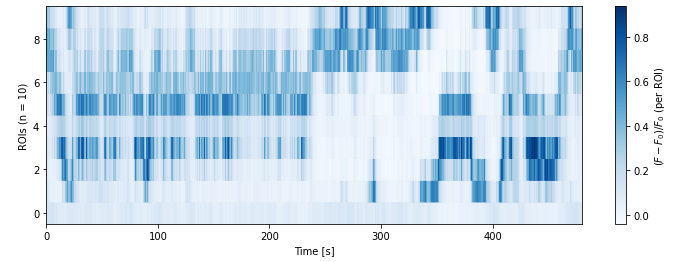

In [24]:
permutation = [0,6,4,8,3,1,7,2,9,5]
fig, ax = plt.subplots(1,1,figsize=(12,4))
plotDFFheatmap(time, centroids[permutation,:], ax, fig)

#### Generate data object and save to disk

In [25]:
roiDf = pd.DataFrame(data = centroids.T, columns = ['roi{}'.format(i+1) for i in range(nclst)])
roiDf['time [s]'] = time
roiDf.head()

,roi1,roi2,roi3,roi4,roi5,roi6,roi7,roi8,roi9,roi10,time [s]
0,0.119619,0.299550,0.451791,0.181494,0.309129,0.347291,0.248027,0.326634,0.394748,0.520847,0.000000
1,0.097575,0.250109,0.394265,0.122315,0.193573,0.280921,0.216163,0.261224,0.246933,0.400940,0.104702
2,0.093401,0.216264,0.369832,0.099990,0.145063,0.279311,0.189898,0.219792,0.187327,0.373066,0.209404
3,0.100004,0.194520,0.365131,0.099645,0.138199,0.316260,0.169882,0.194756,0.181271,0.401341,0.314107
4,0.109096,0.184276,0.363358,0.099355,0.142378,0.360827,0.158347,0.176881,0.189935,0.447561,0.418809


In [26]:
expMetadata = {
    'tiffilename': rawTiff,
    'genotype': genotype,
    'flyid': flyID,
    'trial':trial,
    'condition':'test',
    'roitype': "corr",
    'brainregion': region
}

imgTS_corrroi = imp.imagingTimeseries(
    imgMetadata = basicMetadat,
    expMetadata = expMetadata,
    refImage = refImg, 
    dffStack = dffXarray, 
    F0stack = F0Xarray,
    roitype = "corr",
    roiMask = kmlabsImg, 
    roiDFF = roiDf
)

path2imgdat = imgTS_corrroi.saveData(preprocDir,'')

In [27]:
# To load data from previously save files into object: 
imgTS_load = imp.loadImagingTimeseries(path2imgdat)